In [215]:
#Imports
import nfl_data_py as nfl
import pandas as pd

In [216]:
weekly_data_2019 = nfl.import_weekly_data([2019], downcast=True)
weekly_data_2019 = weekly_data_2019.loc[weekly_data_2019['season_type'] == 'REG']

# standardize team names
weekly_data_2019['recent_team'] = weekly_data_2019['recent_team'].replace({'LA': 'LAR', 'OAK': 'LV'})
weekly_data_2019['opponent_team'] = weekly_data_2019['opponent_team'].replace({'LA': 'LAR', 'OAK': 'LV'})

#drop irrelevant positions
relevent_positions = ['QB', 'RB', 'WR', 'TE']
weekly_data_2019 = weekly_data_2019.loc[weekly_data_2019['position'].isin(relevent_positions)]

#drop final week of season
weekly_data_2019 = weekly_data_2019.loc[weekly_data_2019['week'] != 17]

weekly_data_2019.head()

Downcasting floats.


,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,25.639999,25.639999
1,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,2,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,24.660000,24.660000
2,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,3,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,20.139999,20.139999
3,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,4,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,3.700000,3.700000
4,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,5,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,23.920000,23.920000


In [217]:
# calculate fantasy points and add to each row
weekly_data_2019['dk_fp'] = weekly_data_2019.apply(
    lambda row: round(
        row['passing_yards'] * 0.04 +
        row['passing_tds'] * 4 +
        row['interceptions'] * -1 +
        row['rushing_yards'] * 0.1 +
        row['rushing_tds'] * 6 +
        row['receiving_yards'] * 0.1 +
        row['receiving_tds'] * 6 +
        row['receptions'] * 1 +
        (row['receiving_fumbles_lost'] + row['rushing_fumbles_lost'] + row['sack_fumbles_lost'] ) * -1 +
        (row['passing_2pt_conversions'] + row['rushing_2pt_conversions'] + row['receiving_2pt_conversions']) * 2 +
        (3 if row['passing_yards'] >= 300 else 0) +
        (3 if row['rushing_yards'] >= 100 else 0) +
        (3 if row['receiving_yards'] >= 100 else 0),
        2
    ),
    axis=1
) 
weekly_data_2019.head()

,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr,dk_fp
0,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,1,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,25.639999,25.639999,28.64
1,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,2,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,24.660000,24.660000,24.66
2,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,3,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,20.139999,20.139999,23.14
3,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,4,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,3.700000,3.700000,4.70
4,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,5,REG,...,NaN,0,NaN,NaN,NaN,NaN,0.0,23.920000,23.920000,27.92


In [218]:
# calculate drafkings points allowed by each defense to each position per week
defense_vs_pos = weekly_data_2019.groupby(['week', 'opponent_team', 'position'])['dk_fp'].sum().reset_index()
defense_vs_pos.rename(columns={'opponent_team': 'defense', 'dk_fp': 'dk_fp_allowed'}, inplace=True)
print(defense_vs_pos)

# calculate cumulative fantasy points allowed by each defense to each position
defense_vs_pos ['mean_dk_points_allowed'] = defense_vs_pos.groupby(['defense', 'position'])['dk_fp_allowed'].expanding().mean().reset_index(level=[0, 1], drop=True)
print(defense_vs_pos)

# merge cumulative points allowed with player data
weekly_data_2019 = weekly_data_2019.merge(
    defense_vs_pos[['week', 'defense', 'position', 'mean_dk_points_allowed']],
    left_on=['week', 'opponent_team', 'position'],
    right_on=['week', 'defense', 'position'],
    how='left'
).drop(columns=['defense']).rename(columns={'mean_dk_points_allowed': 'defense_vs_pos'})
print(weekly_data_2019)

      week defense position  dk_fp_allowed
0        1     ARI       QB          31.60
1        1     ARI       RB          16.70
2        1     ARI       TE          30.60
3        1     ARI       WR          50.60
4        1     ATL       QB          14.32
...    ...     ...      ...            ...
1913    16     TEN       WR          39.30
1914    16     WAS       QB          38.28
1915    16     WAS       RB          46.90
1916    16     WAS       TE          21.50
1917    16     WAS       WR          53.20

[1918 rows x 4 columns]
      week defense position  dk_fp_allowed  mean_dk_points_allowed
0        1     ARI       QB          31.60               31.600000
1        1     ARI       RB          16.70               16.700000
2        1     ARI       TE          30.60               30.600000
3        1     ARI       WR          50.60               50.600000
4        1     ATL       QB          14.32               14.320000
...    ...     ...      ...            ...               

In [219]:
# Load regular season schedule
schedule = nfl.import_schedules([2019]).loc[nfl.import_schedules([2019])['game_type'] == 'REG']

# normalize team names
schedule['home_team'] = schedule['home_team'].replace({'LA': 'LAR', 'OAK': 'LV'})
schedule['away_team'] = schedule['away_team'].replace({'LA': 'LAR', 'OAK': 'LV'})

# determine if a player is playing at home or away
weekly_data_2019 = weekly_data_2019.merge(
    schedule[['week', 'home_team', 'away_team']],
    left_on=['week', 'recent_team'],
    right_on=['week', 'home_team'],
    how='left'
)
weekly_data_2019['home'] = weekly_data_2019['recent_team'] == weekly_data_2019['home_team']
weekly_data_2019.drop(columns=['home_team', 'away_team'], inplace=True)
print(weekly_data_2019)

       player_id player_name player_display_name position position_group  \
0     00-0019596     T.Brady           Tom Brady       QB             QB   
1     00-0019596     T.Brady           Tom Brady       QB             QB   
2     00-0019596     T.Brady           Tom Brady       QB             QB   
3     00-0019596     T.Brady           Tom Brady       QB             QB   
4     00-0019596     T.Brady           Tom Brady       QB             QB   
...          ...         ...                 ...      ...            ...   
4562  00-0035719    D.Samuel        Deebo Samuel       WR             WR   
4563  00-0035719    D.Samuel        Deebo Samuel       WR             WR   
4564  00-0035719    D.Samuel        Deebo Samuel       WR             WR   
4565  00-0035719    D.Samuel        Deebo Samuel       WR             WR   
4566  00-0035719    D.Samuel        Deebo Samuel       WR             WR   

                                           headshot_url recent_team  season  \
0     ht

In [220]:
# create a new DataFrame that combines the home and away scores for each team for each week
home_scores = schedule[['week', 'home_team', 'home_score']].rename(columns={'home_team': 'team', 'home_score': 'score'})
away_scores = schedule[['week', 'away_team', 'away_score']].rename(columns={'away_team': 'team', 'away_score': 'score'})
total_scores = pd.concat([home_scores, away_scores])

# group this DataFrame by week and team, and calculate the sum of the scores
total_scores_by_week = total_scores.groupby(['week', 'team']).sum().reset_index()

# calculate the running average of these sums
total_scores_by_week['avg_score'] = total_scores_by_week.groupby('team')['score'].expanding().mean().round(2).reset_index(level=0, drop=True)

# create a column that holds the previous week's average. If there is no previous week, use the average of all weeks
total_scores_by_week['prev_avg_score'] = total_scores_by_week.groupby('team')['avg_score'].shift(1)
total_scores_by_week['prev_avg_score'] = total_scores_by_week['prev_avg_score'].fillna(total_scores_by_week['avg_score'].mean().round(2))

# calculate running average of last 3 weeks, otherwise use the average of all weeks
total_scores_by_week['avg_score_last_3'] = total_scores_by_week.groupby('team')['score'].rolling(window=3).mean().round(2).reset_index(level=0, drop=True)
total_scores_by_week['avg_score_last_3'] = total_scores_by_week['avg_score_last_3'].fillna(total_scores_by_week['avg_score'])

print(total_scores_by_week)

     week team  score  avg_score  prev_avg_score  avg_score_last_3
0       1  ARI   27.0      27.00           22.57             27.00
1       1  ATL   12.0      12.00           22.57             12.00
2       1  BAL   59.0      59.00           22.57             59.00
3       1  BUF   17.0      17.00           22.57             17.00
4       1  CAR   27.0      27.00           22.57             27.00
..    ...  ...    ...        ...             ...               ...
507    17  SEA   21.0      25.31           25.60             21.33
508    17   SF   26.0      29.94           30.20             27.33
509    17   TB   22.0      28.62           29.07             26.67
510    17  TEN   35.0      25.12           24.47             28.00
511    17  WAS   16.0      16.62           16.67             26.00

[512 rows x 6 columns]


In [221]:
# calculate implied team totals
betting_lines = schedule.loc[:, ['week', 'home_team', 'away_team', 'total_line', 'spread_line']]

betting_lines['implied_home_total'] =  betting_lines['total_line'] / 2 + betting_lines['spread_line'] / 2
betting_lines['implied_away_total'] =  betting_lines['total_line'] / 2 - betting_lines['spread_line'] / 2
betting_lines

,week,home_team,away_team,total_line,spread_line,implied_home_total,implied_away_total
5316,1,CHI,GB,47.0,3.5,25.25,21.75
5317,1,CAR,LAR,49.5,-1.5,24.00,25.50
5318,1,CLE,TEN,44.0,5.5,24.75,19.25
5319,1,JAX,KC,49.0,-3.5,22.75,26.25
5320,1,MIA,BAL,41.0,-7.0,17.00,24.00
...,...,...,...,...,...,...,...
5567,17,HOU,TEN,43.0,-10.0,16.50,26.50
5568,17,JAX,IND,41.5,-5.0,18.25,23.25
5569,17,LAR,ARI,46.0,7.0,26.50,19.50
5570,17,NYG,PHI,44.0,-4.0,20.00,24.00


In [222]:
# Merge with previous average scores for comparison
betting_lines = betting_lines.merge(
    total_scores_by_week[['week', 'team', 'prev_avg_score']],
    left_on=['week', 'home_team'],
    right_on=['week', 'team'],
    how='left'
).rename(columns={'prev_avg_score': 'home_prev_avg_score'}).drop(columns=['team'])
betting_lines = betting_lines.merge(
    total_scores_by_week[['week', 'team', 'prev_avg_score']],
    left_on=['week', 'away_team'],
    right_on=['week', 'team'],
    how='left'
).rename(columns={'prev_avg_score': 'away_prev_avg_score'}).drop(columns=['team'])

betting_lines['home_implied_total_diff'] = betting_lines['implied_home_total'] - betting_lines['home_prev_avg_score']
betting_lines['away_implied_total_diff'] = betting_lines['implied_away_total'] - betting_lines['away_prev_avg_score']

betting_lines

,week,home_team,away_team,total_line,spread_line,implied_home_total,implied_away_total,home_prev_avg_score,away_prev_avg_score,home_implied_total_diff,away_implied_total_diff
0,1,CHI,GB,47.0,3.5,25.25,21.75,22.57,22.57,2.68,-0.82
1,1,CAR,LAR,49.5,-1.5,24.00,25.50,22.57,22.57,1.43,2.93
2,1,CLE,TEN,44.0,5.5,24.75,19.25,22.57,22.57,2.18,-3.32
3,1,JAX,KC,49.0,-3.5,22.75,26.25,22.57,22.57,0.18,3.68
4,1,MIA,BAL,41.0,-7.0,17.00,24.00,22.57,22.57,-5.57,1.43
...,...,...,...,...,...,...,...,...,...,...,...
251,17,HOU,TEN,43.0,-10.0,16.50,26.50,24.27,24.47,-7.77,2.03
252,17,JAX,IND,41.5,-5.0,18.25,23.25,17.47,22.73,0.78,0.52
253,17,LAR,ARI,46.0,7.0,26.50,19.50,24.20,22.47,2.30,-2.97
254,17,NYG,PHI,44.0,-4.0,20.00,24.00,21.60,23.40,-1.60,0.60


In [223]:

# merge implied_total_diff with player data
# if home = True, use home_implied_total_diff, else use away_implied_total_diff
weekly_data_2019 = weekly_data_2019.merge(
    betting_lines[['week', 'home_team', 'home_implied_total_diff']],
    left_on=['week', 'recent_team'],
    right_on=['week', 'home_team'],
    how='left'
).merge(
    betting_lines[['week', 'away_team', 'away_implied_total_diff']],
    left_on=['week', 'recent_team'],
    right_on=['week', 'away_team'],
    how='left'
)

# use home_implied_total_diff if home = True, else use away_implied_total_diff
weekly_data_2019['implied_total_diff'] = weekly_data_2019['home_implied_total_diff']
weekly_data_2019.loc[~weekly_data_2019['home'], 'implied_total_diff'] = weekly_data_2019['away_implied_total_diff']

# clean up redundant columns
weekly_data_2019.drop(columns=['home_team', 'away_team', 'home_implied_total_diff', 'away_implied_total_diff'], inplace=True)
weekly_data_2019



,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr,dk_fp,defense_vs_pos,home,implied_total_diff
0,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,1,REG,...,NaN,NaN,NaN,0.0,25.639999,25.639999,28.64,28.640000,True,4.68
1,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,2,REG,...,NaN,NaN,NaN,0.0,24.660000,24.660000,24.66,34.160000,False,0.25
2,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,3,REG,...,NaN,NaN,NaN,0.0,20.139999,20.139999,23.14,20.553333,True,-6.25
3,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,4,REG,...,NaN,NaN,NaN,0.0,3.700000,3.700000,4.70,12.000000,False,-11.08
4,00-0019596,T.Brady,Tom Brady,QB,QB,https://static.www.nfl.com/image/private/f_aut...,NE,2019,5,REG,...,NaN,NaN,NaN,0.0,23.920000,23.920000,27.92,23.868000,False,-1.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4562,00-0035719,D.Samuel,Deebo Samuel,WR,WR,https://static.www.nfl.com/image/private/f_aut...,SF,2019,12,REG,...,0.105263,0.148760,0.262027,0.0,11.000000,13.000000,13.00,31.609091,True,-4.00
4563,00-0035719,D.Samuel,Deebo Samuel,WR,WR,https://static.www.nfl.com/image/private/f_aut...,SF,2019,13,REG,...,0.190476,0.297468,0.493942,0.0,12.100000,14.100000,14.10,35.650000,False,-10.43
4564,00-0035719,D.Samuel,Deebo Samuel,WR,WR,https://static.www.nfl.com/image/private/f_aut...,SF,2019,14,REG,...,0.228571,0.179039,0.468185,0.0,10.900000,15.900000,15.90,40.661538,False,-7.08
4565,00-0035719,D.Samuel,Deebo Samuel,WR,WR,https://static.www.nfl.com/image/private/f_aut...,SF,2019,15,REG,...,0.090909,0.175573,0.259264,0.0,3.700000,4.700000,4.70,36.571429,True,-0.29


In [224]:
QB_COLUMNS = ['player_id', 'player_display_name', 'week', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'interceptions', 'sack_fumbles_lost', 
              'passing_air_yards', 'passing_yards_after_catch', 'passing_epa', 'pacr', 'dakota', 'carries', 'rushing_yards', 
              'dk_fp', 'defense_vs_pos', 'implied_total_diff']
qb_data = weekly_data_2019.loc[weekly_data_2019['position'] == 'QB']
qb_data = qb_data[QB_COLUMNS]
qb_data = qb_data[qb_data['attempts'] > 10]


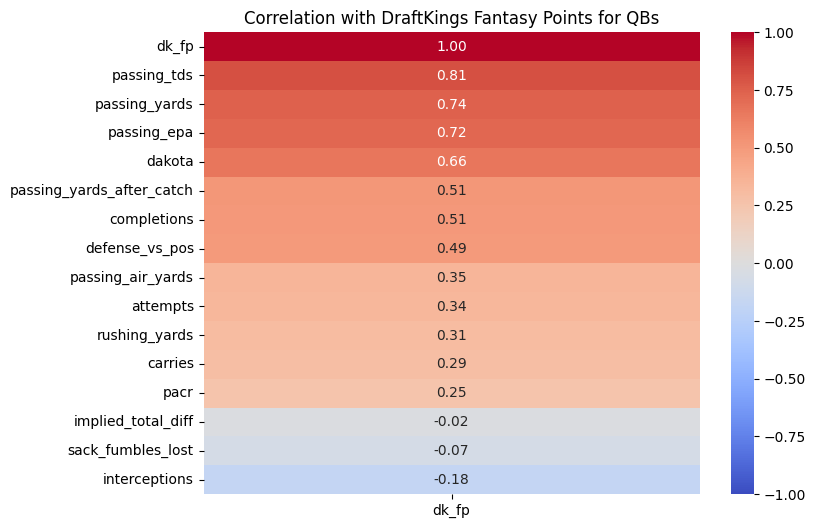

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

# build correlation matrix for QB data
qb_data_for_corr = qb_data.drop(columns=['player_id', 'player_display_name', 'week'])
qb_corr = qb_data_for_corr.corr()

dk_fp_corr = qb_corr[['dk_fp']].sort_values(by='dk_fp', ascending=False)

plt.figure(figsize=(8, 6))

sns.heatmap(dk_fp_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)

plt.title("Correlation with DraftKings Fantasy Points for QBs")
plt.show()


In [232]:
# prepare the data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
features = qb_data[QB_COLUMNS].drop(columns=['player_id', 'player_display_name', 'week', 'dk_fp'])
target = qb_data['dk_fp']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [238]:
# evaluate different models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{model.__class__.__name__} MAE: {mae}, MSE: {mse}")

models = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=42),
    RandomForestRegressor(random_state=42),
    GradientBoostingRegressor(random_state=42)
]

# evaluate each model
for model in models:
    evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test)
    if (isinstance(model, LinearRegression)):
        intercept = model.intercept_
        coefficients = model.coef_
        print(f"Linear Regression Equation: y = {intercept:.4f}", end="")
        for i, coef in enumerate(coefficients):
            print(f" + ({coef:.4f} * {features.columns[i]})", end="")
        print()

LinearRegression MAE: 1.7139781870023765, MSE: 4.65894981618349
Linear Regression Equation: y = 18.1838 + (-0.4359 * completions) + (0.6893 * attempts) + (3.5162 * passing_yards) + (4.0807 * passing_tds) + (-0.7680 * interceptions) + (-0.1890 * sack_fumbles_lost) + (0.3730 * passing_air_yards) + (0.2654 * passing_yards_after_catch) + (0.1106 * passing_epa) + (-0.0804 * pacr) + (1.1151 * dakota) + (0.7063 * carries) + (2.3377 * rushing_yards) + (0.1042 * defense_vs_pos) + (0.3373 * implied_total_diff)
DecisionTreeRegressor MAE: 2.645714285714286, MSE: 16.44911020408163
RandomForestRegressor MAE: 1.8645836734693897, MSE: 6.689017911836738
GradientBoostingRegressor MAE: 1.8411341101181733, MSE: 6.125832191010827
